# Eqcirc1.py

In [2]:
!ls

README.md            eqcirc1.ipynb        eqcirc1.py           sampleadmittance.txt


Here's the program:

In [ ]:
# --
# File: eqcirc1.py
# Equivalent Circuit Parameter Estimator for Piezoelectric Structures
# Author: D. S. Stutts
# Associate Professor of Mechanical Engineering
# 282 Toomey Hall
# 400 W. 13th St.
# Rolla, MO 65409-0050
# Email: stutts@mst.edu
# Original release: Version 0.1.0 3-29-2015
####################--
"""
This program calculates the equivalent 
circuit parameters from frequency-admittance 
magnitude data stored in the standard
HP4294A Impedance Analyser output data
format.

An image of the equivalent circuit may be
found here:
http://web.mst.edu/~stutts/piezoequivcircuit0.png

The program first calculates the approximate
equivalent circuit parameters for a single
resonance-antiresonance frequency pair.
It then uses the Levenberg-Marquardt (LM)
nonlinear least squares algorithm to
optimize the model in the least squares
sense.  The LM algorithm is invoked
via a call to leastsq(rez, z0, args=(yy, xx),
full_output=1) from the scipy.optimize library.

See: http://docs.scipy.org/doc/scipy-0.14.0/
reference/generated/scipy.optimize.leastsq.html
for more information.

eqcirc2.py calculates the following outputs stdout: 

(1) fr (the resonance frequency)
(2) fa (the anti-resonance frequency)
(3) C0 (the parallel capacitance)
(4) R1 (the motional resistance)
(5) L1 (the motional inductance)
(6) C1 (the motional capacitance)
(7) Q (the series R1L1C1 resonance 
       quality factor = 1/2zeta)

A graph of the data and model is also produced.

Example call: python eqcirc1.py inputdatafile.txt

The graph may be saved in PNG format, and the text
may be redirected from stdout to a file like so:

python eqcirc1.py inputdatafile.txt > outdata.txt

 # This code is copyrighted by the author, but released under the MIT
 # license:

Copyright (c) 2015 eqcirc1.py 

S&T and the University of Missouri Board of Curators 
license to you the right to use, modify, copy, and distribute this 
code subject to the MIT license:

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included 
in all copies or substantial portions of the Software. 

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL 
THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING 
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER 
DEALINGS IN THE SOFTWARE.

The author kindly requests that any publications benefitting from the use
of this software include the following citation: 

@Misc{eqcirc1_2015,
author =   {Stutts, D. S.},
title = {{eqcirc1.py}: {Equivalent Circuit Parameter Estimator 
for Piezoelectric Structures.}},
howpublished = {\url{https://github.com/MSTESG/EQCIRC1.git}},
year = {2015}}

"""


from pylab import *
from scipy.optimize import leastsq
# Initialize some lists:
ydat = []
x = []
xx = []
yy = []
# Define functions:
def y(f, z):  # Admittance model
    return 0.2e1 * np.pi * f * np.sqrt(0.4e1 * z[0] ** 2*z[3]**2*
    z[1] ** 2 * np.pi ** 2 * f ** 2 + (
    -0.4e1 * z[0] * z[3] * z[2] * np.pi ** 2 * f ** 2
    + z[0]+z[3])**2)*((-0.4e1 * z[3]*z[2]*np.pi ** 2*f**2+0.1e1)**2
    + 0.4e1*z[1]**2*z[3]**2*np.pi**2*f**2)**(-0.1e1/0.2e1)


def C0_i(Ymin, Ymax, fr, fa):  # Parallel capacitance estimate
    return np.sqrt(0.2e1*(fa ** 2 - fr**2)*Ymin**2/np.pi**2/fa**4
    + 0.2e1*np.sqrt((fa ** 2 - f ** 2)**2/np.pi**4/fa**8*Ymin**4
    + 0.4e1*Ymin**2*Ymax**2/np.pi**4/fa**4))/0.4e1


def R1_i(Ymin, Ymax, fr, fa, C0):  # Motional resistance estimate
    return (-0.4e1*np.pi**2*fr**2*C0**2+Ymax**2)**(-0.1e1/0.2e1)


def L1_i(fr, fa, C0):  # Motional inductance estimate
    return 0.1e1 / np.pi ** 2 / (fa ** 2 - fr ** 2) / C0 / 0.4e1


def C1_i(fr, fa, C0):  # Motional capacitance estimate
    return (fa ** 2 / fr ** 2 - 1) * C0


def rez(z, ydat, f):  # Residual function
    return ydat - y(f, z)

# Input data file on command line:	
infile = sys.argv[1]
data = open(infile, "r")  # get array out of input file
numline = 0
  # read the 21st through 821 lines from the data file
  # and fill x,y lists with floating point numbers:
for line in data:
    if numline > 20 and numline < 822:
        x.append(map(float, (line[0:31]).split())[0])
        ydat.append(map(float, (line[0:31]).split())[1])
    numline += 1
xx = array(x)
yy = array(ydat)

# Locate Ymax, fr, Ymin, and fa:
f = 0
Ymax = 0
imax = len(x)
kmax = 0
for k in range(imax):
    if ydat[k] > ydat[kmax]:
        kmax = k

Ymax = ydat[kmax]
fr = x[kmax]

kmin = kmax

for k in xrange(kmin, imax):
    if ydat[k] < ydat[kmin]:
        kmin = k

Ymin = ydat[kmin]
fa = x[kmin]

print "Ymax = ", Ymax, " at fr = ", fr, "\n"
print "Ymin = ", Ymin, " at fa = ", fa, "\n"

# Estimate initial parameter values:

C0i = C0_i(Ymin, Ymax, fr, fa)
R1i = R1_i(Ymin, Ymax, fr, fa, C0_i(Ymin, Ymax, fr, fa))
L1i = L1_i(fr, fa, C0_i(Ymin, Ymax, fr, fa))
C1i = C1_i(fr, fa, C0_i(Ymin, Ymax, fr, fa))
"""
# Print the initial values: (uncomment if you want 
# to see the approximate values)
print "fr = ", fr,"\n"
print "fa = ", fa,"\n"
print "C0i = ", C0i,"\n"
print "R1i = ", R1i,"\n"
print "L1i = ", L1i,"\n"
print "C1i = ", C1i,"\n"
Qi = 1/(R1i*np.sqrt(C1i/L1i))
print "Qi = ", Qi,"\n"
"""
# Create initial guess array:
z0 = [C0i, R1i, L1i, C1i]

# Find the best values:
output = leastsq(rez, z0, args=(yy, xx), full_output=1)

C0 = output[0][0]
R1 = output[0][1]
L1 = output[0][2]
C1 = output[0][3]
Q = 1 / (R1 * np.sqrt(C1 / L1))
fr = 1 / np.sqrt(L1 * C1) / 0.2e1 / np.pi
fa = np.sqrt((C0 + C1) / C0 / C1 / L1) / np.pi / 0.2e1

# Print the results:
print "fr = ", fr, "\n"
print "fa = ", fa, "\n"
print "C0 = ", C0, "\n"
print "R1 = ", R1, "\n"
print "L1 = ", L1, "\n"
print "C1 = ", C1, "\n"
print "Q = ", Q, "\n"

# Put the optimal values in an array:
coeffs = [C0, R1, L1, C1]

# Plot the model and the data:
plt.plot(xx, y(xx, coeffs), 'r-', label='model')
plt.plot(xx, ydat, 'go', label='data')
legend = plt.legend(loc='upper right', shadow=True, fontsize='large')
xlabel('f (Hz)')
ylabel('Y (A/V)')
grid(True)
# Put a nice background color on the legend:
legend.get_frame().set_facecolor('#00FFCC')
plt.show()

Here's a list of the so-called magic commands:

In [1]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %install_default_config  %install_ext  %install_profiles  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%latex  %%

In [2]:
ls

README.md             eqcirc1.ipynb         eqcirc1.py            sampleadmittance.txt


Let's run eqcirc1.py:

In [4]:
run eqcirc1.py sampleadmittance.txt

Ymax =  0.00961523  at fr =  112679.322 

Ymin =  0.0002012571  at fa =  114242.119 

fr =  112719.998047 

fa =  114099.640027 

C0 =  1.53668657292e-09 

R1 =  106.327684938 

L1 =  0.0526754085687 

C1 =  3.78469080709e-11 

Q =  350.866896655 



The above are the least squares model parameters returned.  If we want the plot to persist in this notebook,
we'll have to save it, and the import it.  First, we need to load the following modules:

In [5]:
from IPython.display import display

In [6]:
from IPython.display import Image

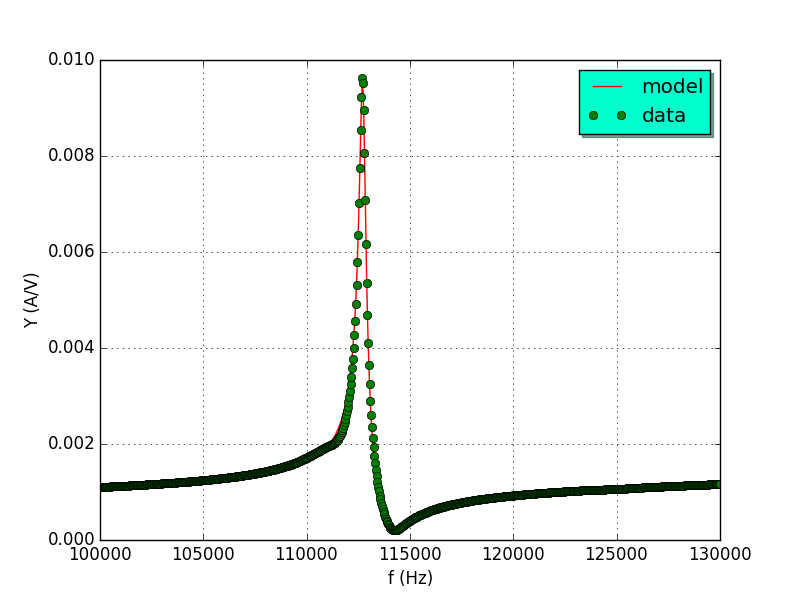

In [7]:
Image(filename='admittance.png')

Looks like a pretty good fit!

Here's the equivalent circuit we're estimating the parameters of:

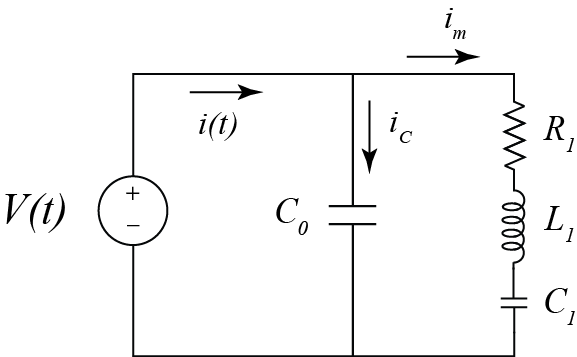

In [9]:
Image(filename='PZTEqCircuit2.png')

Oh, and here's the admittance magnitude model:

In [19]:
from IPython.display import Latex

In [20]:
Latex(r"""\begin{equation}|Y(f)|=2\pi\,f\sqrt{\frac{4\pi^2C_0^2C_1^2R_1^2f^2+\left(C_0+C_1-4\pi^2C_0C_1L_1f^2 \right)^2}{\left(1-4\pi^2L_1C_1f^2 \right)^2+4\pi^2R_1^2C_1^2f^2}}\end{equation}""")

<IPython.core.display.Latex object>

More later...